# Ingest data from data source to S3 bucket

***

## Libraries

In [2]:
import sagemaker
import boto3
from datetime import datetime
from io import StringIO
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import plotly.figure_factory as ff

## Variables

In [3]:
sess = sagemaker.Session() #Intialzie session

bucket = sess.default_bucket()
RD_Bucket = 'sdpd-bucket' #Raw Data
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3 = boto3.client('s3') # Create an S3 client
s3_resource = boto3.resource('s3') # Create an S3 resource

print('Bucket - > ',bucket)
print('Role - > ',role)
print('Region - > ',region)
print('S3 - > ',s3)
print('S3 Resource - > ',s3_resource)

Bucket - >  sagemaker-us-east-1-109424293498
Role - >  arn:aws:iam::109424293498:role/LabRole
Region - >  us-east-1
S3 - >  <botocore.client.S3 object at 0x7fb79b3bd090>
S3 Resource - >  s3.ServiceResource()


## Prepare landing zone

In [4]:
# Function to verify if bucket exist, if not create
def verify_create_bucket(bucket_name):
    response = s3.list_buckets()
    for bucket in response['Buckets']:
        if bucket['Name'] == bucket_name:
            print(f"The {bucket_name} bucket exists.")
            break
    else:
        print(f"The {bucket_name} bucket does not exist, creating")
        !aws s3 mb s3://{RD_Bucket}/

In [5]:
verify_create_bucket(RD_Bucket)

The sdpd-bucket bucket exists.


## Download Files

***

### Load calls

In [6]:
#function to download yearly data
def Get_Data(year):
    url = f"https://seshat.datasd.org/pd/pd_calls_for_service_{year}_datasd.csv"
    df = pd.read_csv(url)
    return df

In [7]:
# List of years since 2018
Years = list(range(2018,datetime.now().year+1))
Years

[2018, 2019, 2020, 2021, 2022, 2023]

In [8]:
sdpd_calls = pd.DataFrame()
#iterate over years
for year in tqdm(Years):
    year_df = Get_Data(year)
    year_df['Year'] = year
    sdpd_calls = pd.concat((sdpd_calls, year_df))

100%|██████████| 6/6 [00:20<00:00,  3.34s/it]


In [9]:
#Verify Shape
sdpd_calls.shape

(2899729, 15)

In [10]:
sdpd_calls = sdpd_calls.drop(['address_dir_intersecting', 'address_sfx_intersecting'], axis=1)

***

In [11]:
type_url = f"http://seshat.datasd.org/pd/pd_cfs_calltypes_datasd.csv"
dipo_url = f"http://seshat.datasd.org/pd/pd_dispo_codes_datasd.csv"
ripa_stops_url = "https://seshat.datasd.org/pd/ripa_stops_datasd.csv"
ripa_stops_dic = "https://seshat.datasd.org/pd/ripa_stops_dictionary_datasd.csv"

In [12]:
def download_file(url):
    df = pd.read_csv(url, low_memory=False)
    return df

In [13]:
type_df = download_file(type_url)
dispo_df = download_file(dipo_url)
ripa_stops_df = download_file(ripa_stops_url)
ripa_stops_dic_df = download_file(ripa_stops_dic)


***

## Data Quality Report

In [47]:
def Data_Quality_Report(df):

    #Initial table
    freqDF = pd.DataFrame(columns=['Feature',
                                   'Mode',
                                   'Mode Freq.',
                                   'Mode %',
                                   '2nd Mode',
                                   '2nd Mode Freq.',
                                   '2nd Mode %'])
    for col in tqdm(df.columns):
        try:
            #print(col)
            freq = df[col].value_counts()
            freqdf = freq.to_frame()
            fRow = freqdf.iloc[0]
            #try:
            secRow = freqdf.iloc[1]
            #except:
            #secRow = 0
            fPrct = fRow[0] / len(df[col])
            #try:
            secPrct = secRow[0] / len(df[col])
            #except:
                #secPrct = 0
            try:
                mode1 = int(fRow.name)
            except:
                mode1 = fRow.name
            try:
                mode2 = int(secRow.name)
            except:
                try:
                    mode2 = secRow.name
                except:
                    mode2 = 0
            freqDF = freqDF.append({'Feature':col,
                                    'Mode':mode1,
                                    'Mode Freq.':fRow[0],
                                    'Mode %':fPrct,\
                                    '2nd Mode':mode2,
                                    '2nd Mode Freq.':secRow[0],
                                    '2nd Mode %':secPrct},
                                    ignore_index=True)
        except:
            pass

    freqDF = freqDF.set_index('Feature')

    #Nulls, Counts, Cardinality
    NUllFeatures = round(df.isnull().sum() / df.shape[0],4)\
          .sort_values(ascending=False)
    Count = df.count()
    uni = df.nunique()

    #Formating
    NUllFeatures.to_frame(name="% Miss.")
    Count.to_frame(name="Count")
    uni.to_frame()
    result = pd.concat([Count, NUllFeatures,uni], axis=1)
    result.columns =["Count","% Miss.","Card."]
    result = pd.concat([result, freqDF], axis=1)
    
    result = result.style.format({'% Miss.': "{:.1%}",
                         'Mode %': "{:.0%}",
                         '2nd Mode %': "{:.0%}",
                         'Count': "{:,}",
                         'Card.': "{:,}",
                         'Mode Freq.': "{:,}",
                        '2nd Mode Freq.': "{:,}"})
    return result

In [48]:
DQR_Calls = Data_Quality_Report(sdpd_calls)
DQR_Calls

100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


In [49]:
DQR_Stops = Data_Quality_Report(ripa_stops_df)
DQR_Stops

100%|██████████| 29/29 [00:00<00:00, 43.89it/s]


***

## Save Date to Buckets

In [17]:
def move_2_bucket(bucket,subfolder_name,file_name,df):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3_resource.Object(bucket,
                       subfolder_name + file_name).put(Body=csv_buffer.getvalue())
    print(file_name,'loaded in',bucket,'bucket')
    

In [18]:
move_2_bucket(RD_Bucket,'Call_Data/','SDPD_Calls.csv',sdpd_calls)
move_2_bucket(RD_Bucket,'Type_Data/','SDPD_Type.csv',type_df)
move_2_bucket(RD_Bucket,'Dispo_Data/','SDPD_Dispo.csv',dispo_df)
move_2_bucket(RD_Bucket,'Stops_Data/','SDPD_Stops.csv',ripa_stops_df)
move_2_bucket(RD_Bucket,'Stops_Dic_Data/','SDPD_Stops_Dic.csv',ripa_stops_dic_df)

SDPD_Calls.csv loaded in sdpd-bucket bucket
SDPD_Type.csv loaded in sdpd-bucket bucket
SDPD_Dispo.csv loaded in sdpd-bucket bucket
SDPD_Stops.csv loaded in sdpd-bucket bucket
SDPD_Stops_Dic.csv loaded in sdpd-bucket bucket


<div class="alert alert-block alert-success">
<b>Data:</b> Loaded in S3 Buckets
</div>

***

## Aggregate Police Acticity by Hour

### Functions

In [19]:
def events_hour(df,freq,date_field,groupby):
    df[date_field]=pd.to_datetime(df[date_field])
    df_group = df.groupby([
        pd.Grouper(key=date_field,freq=freq),
        groupby
    ]).size().reset_index(name='count')
    
    return df_group

In [20]:
def events_timeseries(df,freq,date_field):
    df[date_field]=pd.to_datetime(df[date_field])
    df_group = df.groupby([
        pd.Grouper(key=date_field,freq=freq)
    ]).size().reset_index(name='count')
    
    return df_group

In [81]:
def categorise(row):  
    if row['count'] > 0 and row['count'] <= 130000:
        return 'Low Quarter'
    elif row['count'] > 150000:
        return 'High Quarter'
    return 'Normal Quarter'

### Datasets

In [82]:
time_series_priority = events_hour(sdpd_calls,'H','date_time','priority')
time_series = events_timeseries(sdpd_calls,'M','date_time')
time_series_hr = events_timeseries(sdpd_calls,'H','date_time')
time_series_q = events_timeseries(sdpd_calls,'Q','date_time')

In [106]:
#Priority
time_series_priority['year'] = time_series_priority['date_time'].dt.year
time_series_prior_2023 = time_series_priority[time_series_priority.year == 2023]


#Monthly
time_series['year'] = time_series['date_time'].dt.year
time_series['month'] = time_series['date_time'].dt.month_name()
time_series_complete = time_series[time_series.year != 2023]

#Quarter
time_series_q['year'] = time_series_q['date_time'].dt.year
time_series_q['quarter'] = pd.PeriodIndex(time_series_q.date_time, freq='Q')
time_series_q['Quarter'] = pd.PeriodIndex(time_series_q['quarter'], freq='Q').strftime('%Y-%m')
time_series_q['Level'] = time_series_q.apply(lambda row: categorise(row), axis=1)
time_series_complete_q = time_series_q[time_series_q.year != 2023]


#Hourly

#time_series_complete_q.head()

date_time   count  year quarter  Quarter           Level
0 2018-03-31  138194  2018  2018Q1  2018-03  Normal Quarter
1 2018-06-30  141197  2018  2018Q2  2018-06  Normal Quarter
2 2018-09-30  148068  2018  2018Q3  2018-09  Normal Quarter
3 2018-12-31  143000  2018  2018Q4  2018-12  Normal Quarter
4 2019-03-31  138913  2019  2019Q1  2019-03  Normal Quarter

In [107]:
time_series_hr

date_time  count
0     2018-01-01 00:00:00    143
1     2018-01-01 01:00:00    134
2     2018-01-01 02:00:00     97
3     2018-01-01 03:00:00     54
4     2018-01-01 04:00:00     42
...                   ...    ...
45643 2023-03-17 19:00:00     60
45644 2023-03-17 20:00:00     56
45645 2023-03-17 21:00:00     57
45646 2023-03-17 22:00:00     72
45647 2023-03-17 23:00:00     45

[45648 rows x 2 columns]

***

## Visualize

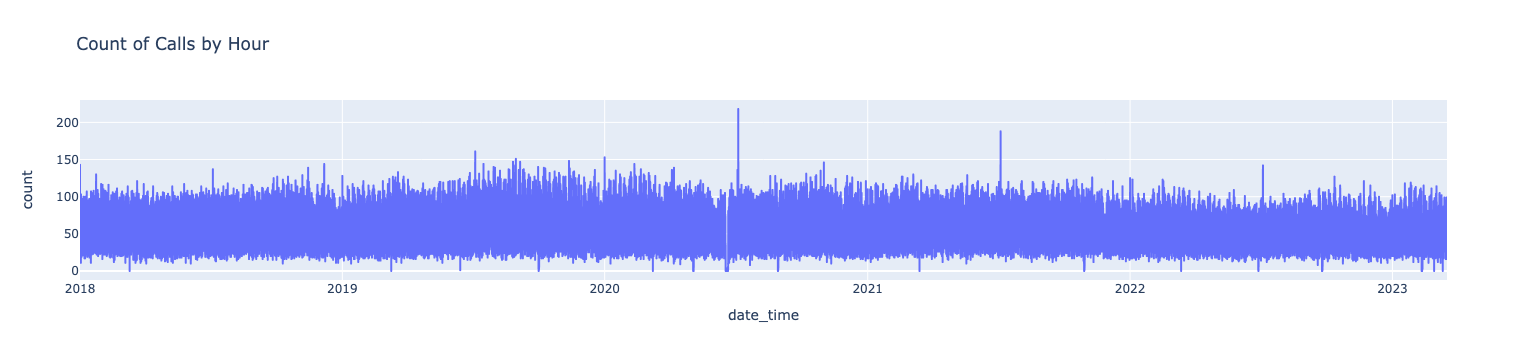

In [115]:
fig = px.line(time_series_hr,
             x='date_time',
             y="count",
             title="Count of Calls by Hour"
             )
fig.show()

In [ ]:
fig = px.line(time_series_prior_2023,
             x='date_time',
             y="count",
             title="Count of Calls by Hour and Priority"
             )
fig.show()

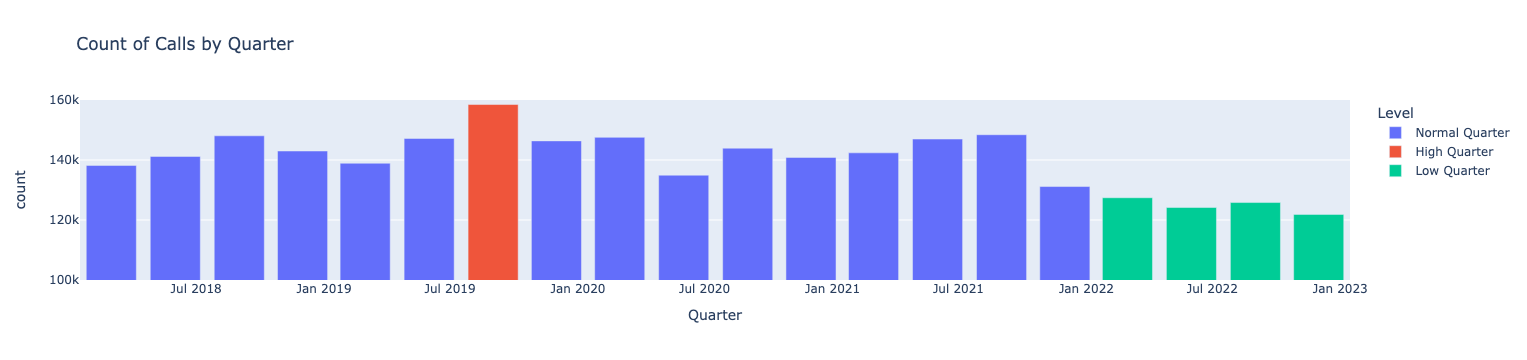

In [116]:
fig = px.bar(time_series_complete_q,
             x='Quarter',
             y="count",
             color='Level',
             #marker_color='Level',
             title="Count of Calls by Quarter"
            )
fig.update_layout(yaxis_range=[100000,160000])
fig.show()

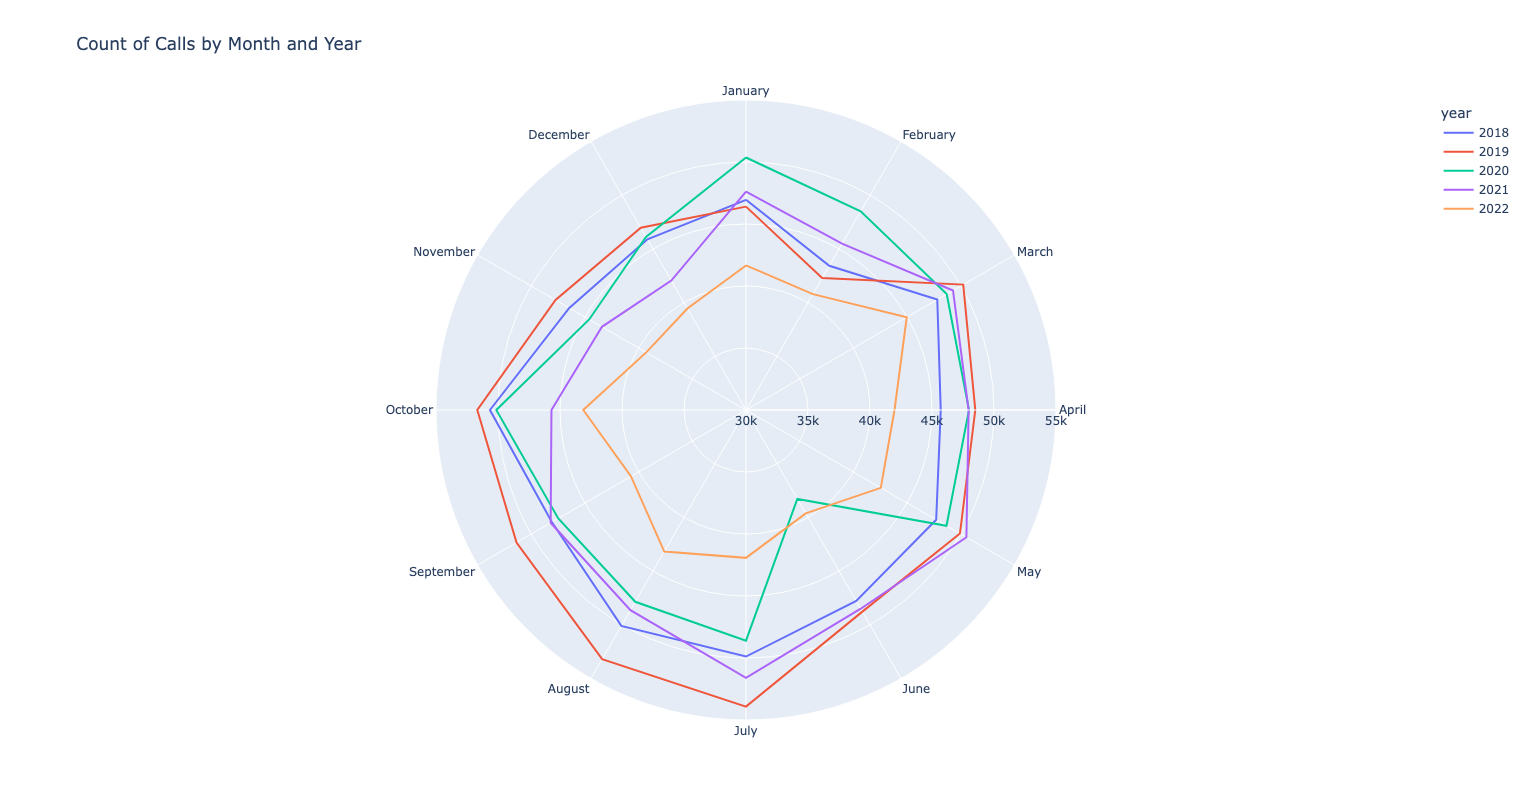

In [112]:
fig = px.line_polar(
    data_frame=time_series_complete, 
    r="count", 
    theta="month", 
    color="year",
    range_r=[30000,55000],
    line_close=True,
    #color_discrete_sequence=px.colors.sequential.Cividis,
    width=800,
    height=800,
    title="Count of Calls by Month and Year"
)
fig.show()

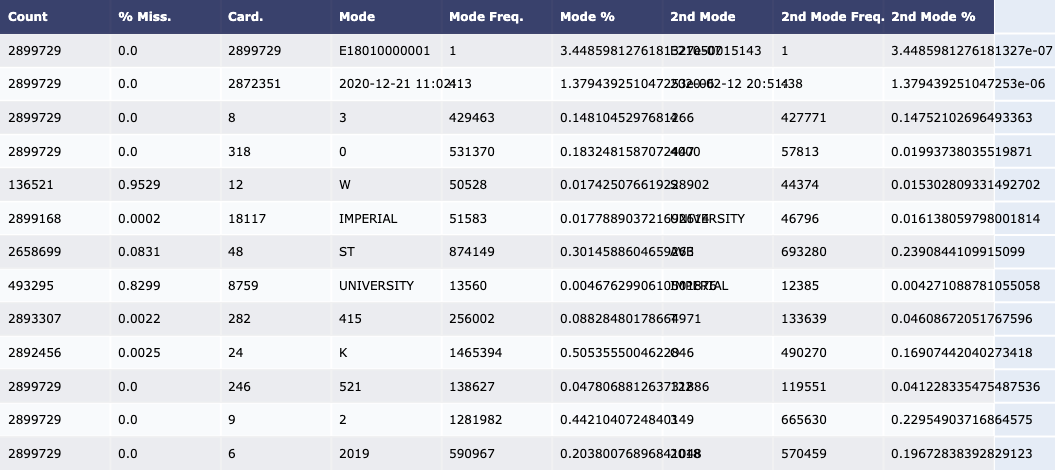

In [27]:
fig = ff.create_table(DQR_Calls)
#fig.layout.DQR_Calls['% Miss.'].cells.format = '.0%'
fig.show()

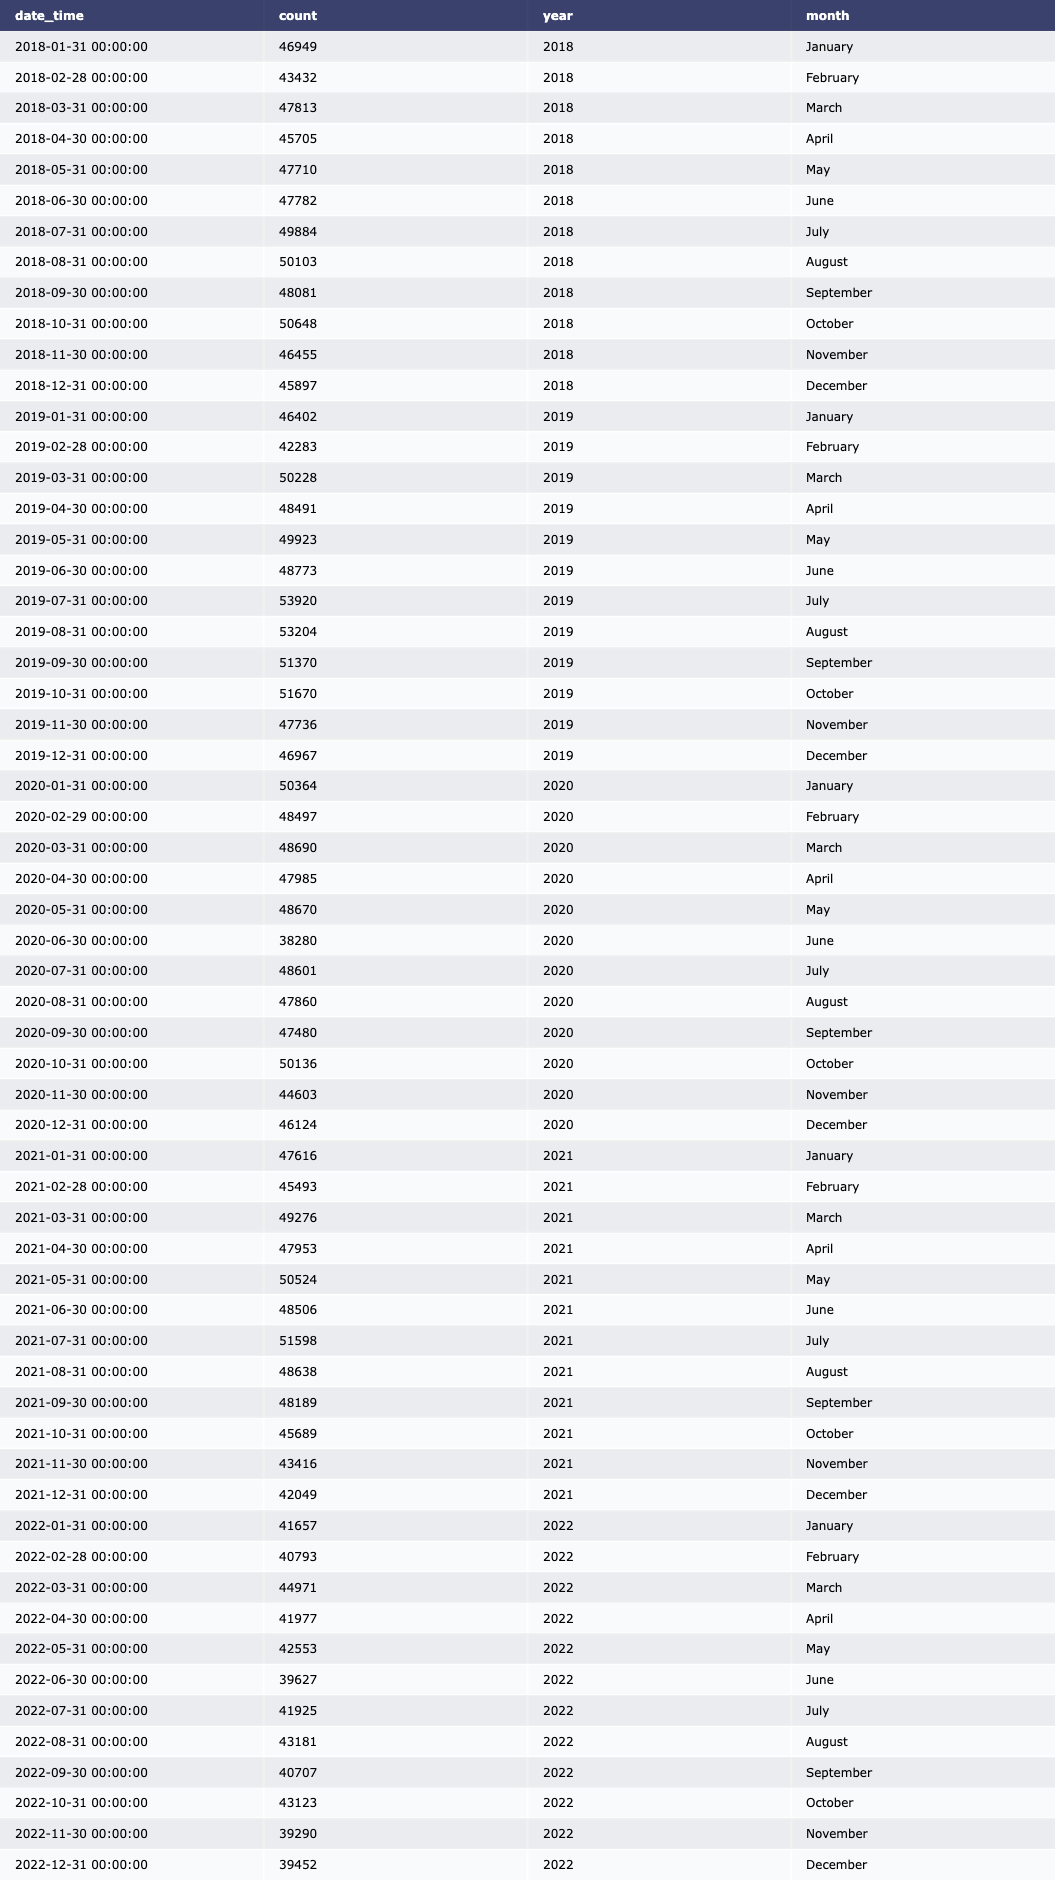

In [28]:
fig = ff.create_table(time_series_complete)
fig.show()

In [29]:
fig = ff.create_table(DQR_Calls)
fig.update_layout(
autosize=False,
width=500,
height=200,
)
fig.write_image("table_plotly.png", scale=2)
fig.show()

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido
